In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


# For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
train_dir = 'train'
test_dir = 'test'

image_height, image_width = 128, 128
batch_size = 32

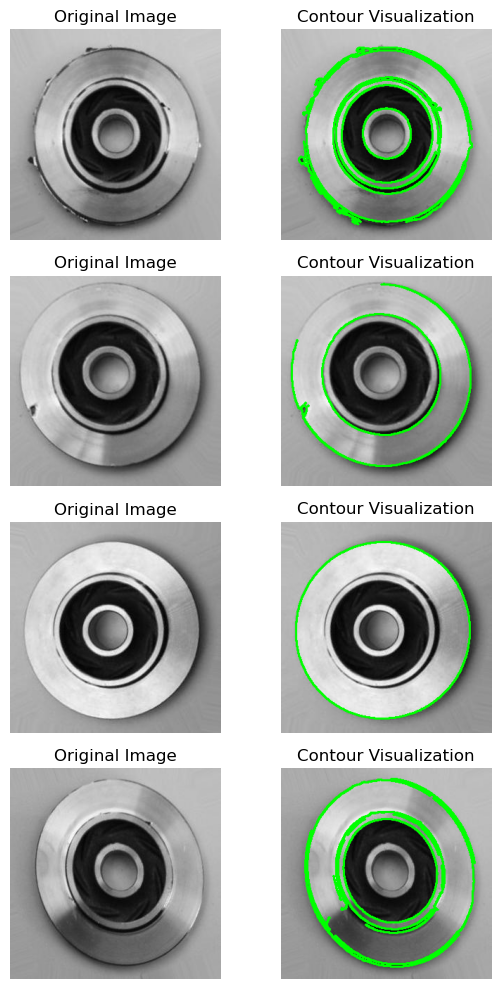

In [5]:
sample_images = [
'train/def_front/cast_def_0_27.jpeg',
'test/def_front/cast_def_0_236.jpeg',
'test/ok_front/cast_ok_0_1020.jpeg',
'test/def_front/cast_def_0_1063.jpeg'
]


fig, axs = plt.subplots(len(sample_images), 2, figsize=(6, 10))


for i, path in enumerate(sample_images):
    if not os.path.exists(path):
        continue
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoured_image = image.copy()
    cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 2)


    axs[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')


    axs[i, 1].imshow(cv2.cvtColor(contoured_image, cv2.COLOR_BGR2RGB))
    axs[i, 1].set_title('Contour Visualization')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip=True,
zoom_range=0.1
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(image_height, image_width),
batch_size=batch_size,
class_mode='binary'
)


test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(image_height, image_width),
batch_size=batch_size,
class_mode='binary',
shuffle=False
)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [7]:
model = models.Sequential([
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.Flatten(),
layers.Dense(64, activation='relu'),
layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\kanis\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,713 (12.47 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
epochs = 20

history = model.fit(
train_generator,
epochs=epochs,
validation_data=test_generator
)

C:\Users\kanis\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.5561 - loss: 0.6926 - val_accuracy: 0.6252 - val_loss: 0.5952
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 635s 3s/step - accuracy: 0.6456 - loss: 0.6303 - val_accuracy: 0.7580 - val_loss: 0.4501
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 732s 4s/step - accuracy: 0.8210 - loss: 0.4041 - val_accuracy: 0.7832 - val_loss: 0.5204
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 73s 338ms/step - accuracy: 0.8503 - loss: 0.3264 - val_accuracy: 0.5608 - val_loss: 1.2884
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 112s 537ms/step - accuracy: 0.9015 - loss: 0.2314 - val_accuracy: 0.7860 - val_loss: 0.5151
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 122s 583ms/step - accuracy: 0.9443 - loss: 0.1489 - val_accuracy: 0.7594 - val_loss: 0.6501
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 123s 588ms/step - accuracy: 0.9392 - loss: 0.1490 - val_accuracy: 0.7105 - val_loss: 0.7994
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 125s 597ms/step - accuracy: 0.9703 - loss: 0.0

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9628 - loss: 0.1358

 Test Accuracy: 0.9720
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step

--- Classification Report ---
              precision    recall  f1-score   support

   def_front       1.00      0.96      0.98       453
    ok_front       0.93      1.00      0.96       262

    accuracy                           0.97       715
   macro avg       0.96      0.98      0.97       715
weighted avg       0.97      0.97      0.97       715



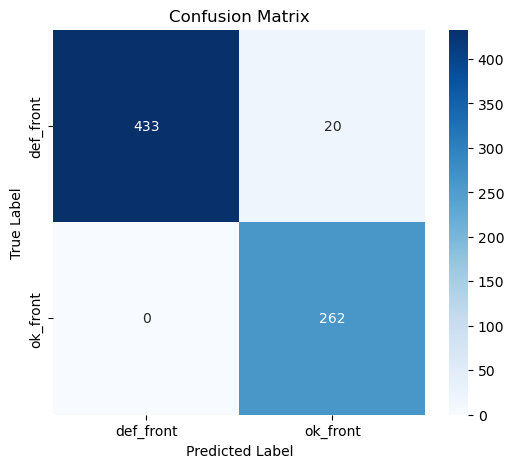

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n Test Accuracy: {test_acc:.4f}")


y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)


print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_generator.class_indices.keys(),
yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
model.save('model.h5')
print("Model saved as model.h5")

Model saved as model.h5


In [11]:
sample_image_path = 'test/ok_front/cast_ok_0_1026.jpeg'
if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    img_resized = cv2.resize(img, (image_height, image_width))
    img_norm = img_resized / 255.0
    pred = model.predict(np.expand_dims(img_norm, axis=0))[0][0]

    if pred > 0.5:
        print(" Non-Defective Casting Detected")
    else:
        print(" Defective Casting Detected")
else:
    print("Sample image not found for prediction.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
 Non-Defective Casting Detected
